# Spatial spectra

## Available snapshot data
```
grep ocean_snapshot /g/data/hh5/tmp/cosima/access-om2-*/*/output*/ocean/diag_table
```

As of 24 May 2019:

`vorticity_z` only:

`01deg_jra55v13_iaf`

`eta_t`, `u`, `v`:

`01deg_jra55v13_ryf8485_spinup6`

`01deg_jra55v13_ryf8485_spinup6_newtopog`

`025deg_jra55v13_iaf_gmredi6`

`025deg_jra55v13_iaf_gmredi6_abswind`

`025deg_jra55v13_iaf_nogmredi6`

`025deg_jra55v13_ryf8485_gmredi6`

`025deg_jra55v13_ryf9091_gmredi6`

`025deg_jra55v13_ryf9091_gmredi6`

so nothing available at 1deg as yet

## Relevant papers
- CapetMcWilliamsMolemakerShchepetkin2008a http://dx.doi.org/10.1175/2007JPO3671.1
- SouffletMarchesielloLemarieJouannoCapetDebreuBenshila2016a http://dx.doi.org/10.1016/j.ocemod.2015.12.004
- Scott Bachman?
- Kitsios?

## also see
- https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html

In [1]:
# import pyfftw # faster but not available - get this installed?
import numpy as np
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import copy
from scipy.fftpack import fft2, fftn, fftshift
import scipy.signal.windows as ssw
# import matplotlib.colors as colors
# import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
# from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
# import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# adjust to reflect available snapshot data
exptdata.exptdict['01deg']['expt'] = '01deg_jra55v13_ryf8485_spinup6'
exptdata.exptdict['01deg']['exptdir'] = '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_spinup6'
del exptdata.exptdict['1deg']

In [3]:
exptdata.exptdict

OrderedDict([('025deg',
              {'model': 'access-om2-025',
               'expt': '025deg_jra55v13_iaf_gmredi6',
               'desc': 'ACCESS-OM2-025',
               'n_files': -34,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6'}),
             ('01deg',
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf8485_spinup6',
               'desc': 'ACCESS-OM2-01',
               'n_files': None,
               'time_units': 'days since 0001-01-01',
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_spinup6'})])

In [4]:
# cc.build_index()

In [5]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [6]:
figdir = ''
# NOSYNC = '/g/data/v45/aek156/figures/ACCESS-OM2-1-025-010deg-report/figures/ice_validation/NOSYNC/' # where to save figs we don't want to sync
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [7]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
# #               'EACACCSouthPacific': [140-360,240-360,-65,-20], 
# #               'EACACC':             [140-360,190-360,-65,-20],
#               'EAC':                     [145-360,175-360,-45,-20],
#               'Kuroshio':                [125-360,155-360,25,50],
#               'GulfStream':             [-85,-50,25,50],
#               'Agulhas':                 [10,40,-45,-20],
    'California Current': [-130, -123, 32, 38], # near ICC domain in fig 1 of CapetMcWilliamsMolemakerShchepetkin2008a http://dx.doi.org/10.1175/2007JPO3671.1
    'Eastern North Pacific': [-200, -123, 10, 33],
    'Southern Ocean': [-250, -220, -60, -45] # Marine's region

    # TODO: ACC
}

In [8]:
use_cache = True

In [9]:
# load model surface EKE snapshots
ekes = copy.deepcopy(exptdata.exptdict)  # this will store EKE fields under the same keys as exptdata.exptdict
for ekey in ekes.keys():
#     if ekey == '025deg':
        expt = ekes[ekey]['expt']
#         n_files = ekes[ekey]['n_files']
        n_files = None

#         n_files = -1

        time_units = ekes[ekey]['time_units']
        offset = ekes[ekey]['offset']
#         print(ekey, n_files)

        ## Load zonal velocity from expt
#         tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'u',n=n_files,time_units=time_units, offset=offset, use_cache=use_cache)
        tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'u',n=n_files, use_cache=use_cache)

        u = tmp.isel(st_ocean=0)#.sel(time=slice(tstart,tend)) #.mean('time')

        ## Load meridional velocity from expt 
#         tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'v',n=n_files,time_units=time_units, offset=offset, use_cache=use_cache)
        tmp = cc.get_nc_variable(expt, 'ocean_snapshot.nc', 'v',n=n_files,use_cache=use_cache)
        v = tmp.isel(st_ocean=0)#.sel(time=slice(tstart,tend)) #.mean('time')
        
        ekes[ekey]['eke'] = (u**2+v**2).fillna(0.0)/2  # fill land with zeros
        
        del(tmp, u, v)

Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_snapshot.nc_u_None_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_snapshot.nc_v_None_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_ryf8485_spinup6_ocean_snapshot.nc_u_None_days-since-1900-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_ryf8485_spinup6_ocean_snapshot.nc_v_None_days-since-1900-01-01_None_False.pkl


In [10]:
def detrend(f,dim): # see Errico1985a sec 2a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
    """
    Detrend multidimensional dataarray f in dimension dim.
    In all other dimensions, remove linear function from first to last element in dimension given by string dim.
    WARNING: can produce a plaid pattern that produces artifacts in fft. Better to use window instead.
    """
    # I don't like using eval but I can't think of a better way right now...
    first = eval('f.isel('+dim+'=0)')
    last = eval('f.isel('+dim+'=-1)')
    n = f[dim].size
    slope = (last-first)/(n-1)
    scale = xr.DataArray(np.arange((1-n)/2,(n+1)/2), coords={dim: f[dim]}, dims=[dim])
    return f-scale*slope # subtract outer product    

In [11]:
def window(f,dim,window='hamming'):
    """
    Apply window to multidimensional dataarray f in dimension dim.
    """
    return f*xr.DataArray(ssw.get_window(window, f[dim].size), coords={dim: f[dim]}, dims=[dim])

In [12]:
def fftgrid(v2):
    """
    FFT squared magnitude, in grid space
    """
    tdim, ydim, xdim = v2.dims  # abstract out dimension names - NB: assumes this order of dimensions
    nx = v2[xdim].size
    ny = v2[ydim].size

#     v2dt = detrend(detrend(v2,'xt_ocean'),'yt_ocean')  # don't use - produces artifacts
    v2dt = window(window(v2,xdim),ydim)
    v2dt = v2dt-v2dt.mean(xdim, skipna=True).mean(ydim, skipna=True)

#     fig = plt.figure(figsize=(12,8))
#     v2dt.isel(time=0).plot()
#     plt.title(locname+' surface enstrophy, windowed, demeaned')

#     v2dtfft = abs(fftn(v2dt, axes=(1,2)))**2  # fft squared amplitude at each time
    v2dtfft = abs(fftn(v2dt, axes=(1,2)))  # fft amplitude at each time

    v2dtfft = v2dtfft.mean(axis=0)  # time-mean
    v2dtfft[0,0] = np.nan  # nan at removed zero frequency
    v2dtfft = fftshift(v2dtfft)  # put zero wavenumber in array centre

    v2dtfft = xr.DataArray(v2dtfft, dims=['kj','ki'], 
                coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                attrs={'long_name': 'wavenumber spectrum in grid units'})
    v2dtfft.ki.attrs['units'] = 'cycles/dx'
    v2dtfft.kj.attrs['units'] = 'cycles/dy'
    v2dtfft.ki.attrs['long_name'] = 'x wavenumber'
    v2dtfft.kj.attrs['long_name'] = 'y wavenumber'
    return v2dtfft

In [13]:
def azimuthal_sum(v2dtfft):
    annuli = np.linspace(0.0, 0.5, num=min(v2dtfft.shape)/2.0)
    v2dtfftradialcsum = 0.0*annuli
    for i,a in enumerate(annuli[1:]):
        v2dtfftradialcsum[i+1] = v2dtfft.where(np.sqrt(v2dtfft.ki**2+v2dtfft.kj**2)<a).sum()
    v2dtfftradial = np.diff(v2dtfftradialcsum)
    v2dtfftradial = xr.DataArray(v2dtfftradial, dims=['k'], coords={'k': annuli[1:]})
    v2dtfftradial.k.attrs['units'] = 'cycles/dx'
    v2dtfftradial.k.attrs['long_name'] = 'wavenumber magnitude'
    return v2dtfftradial

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


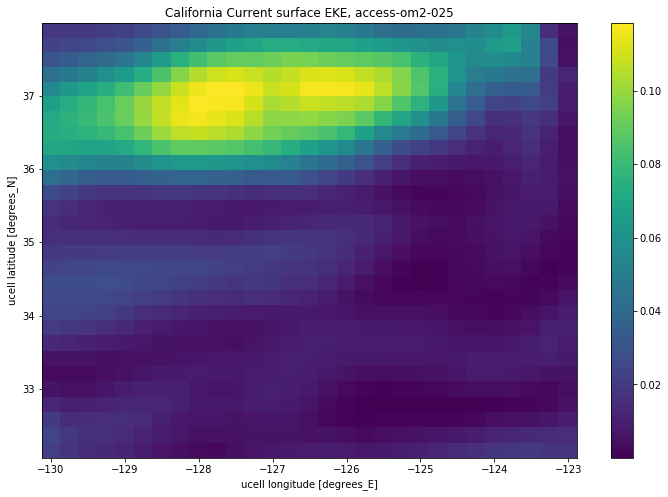

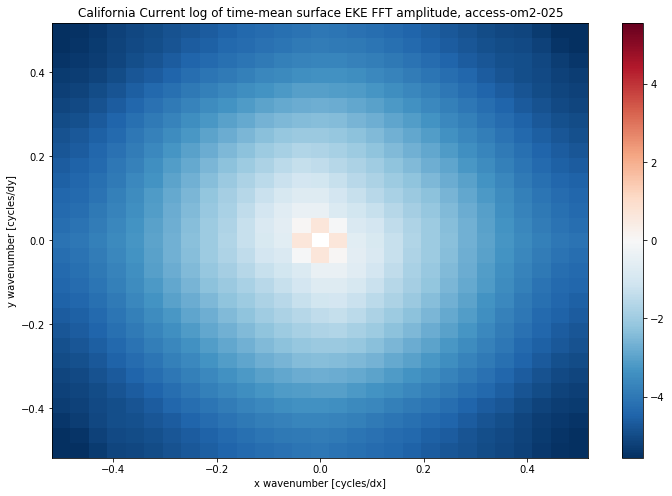

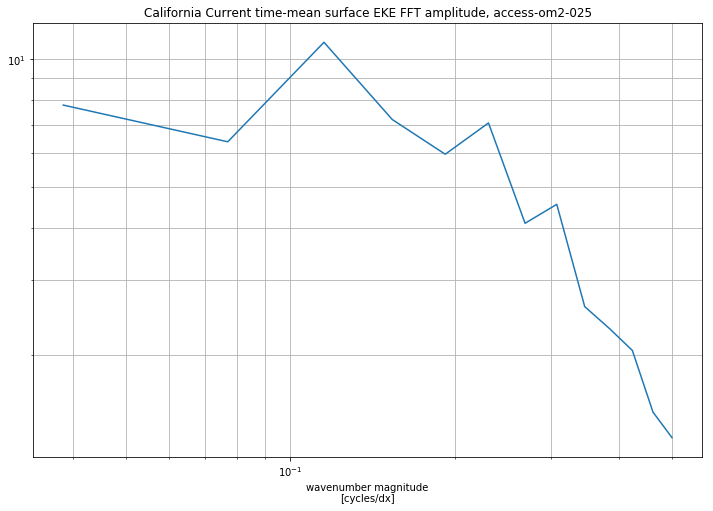

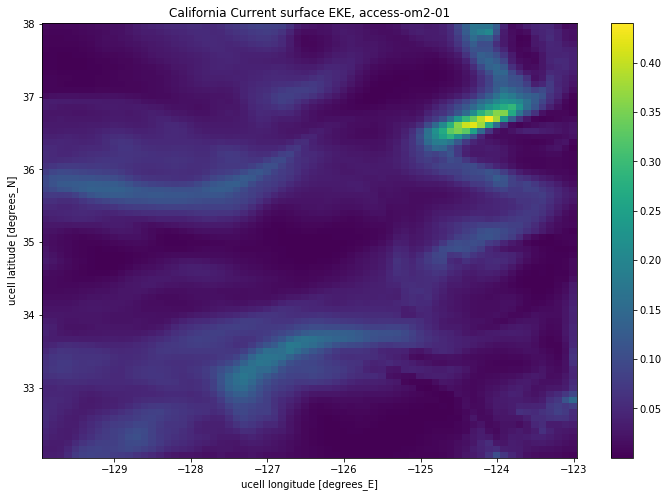

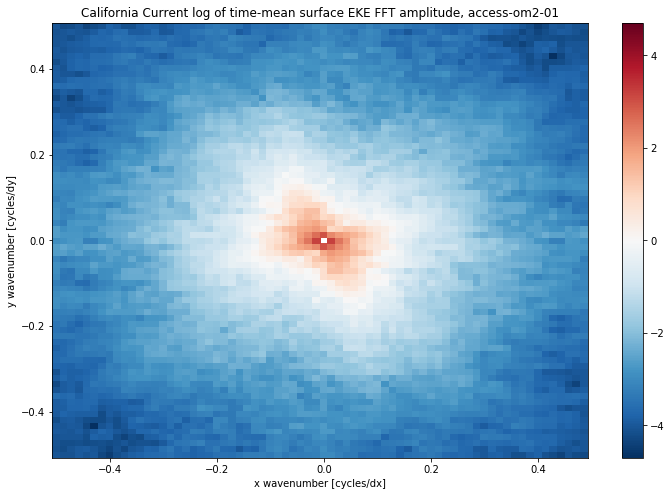

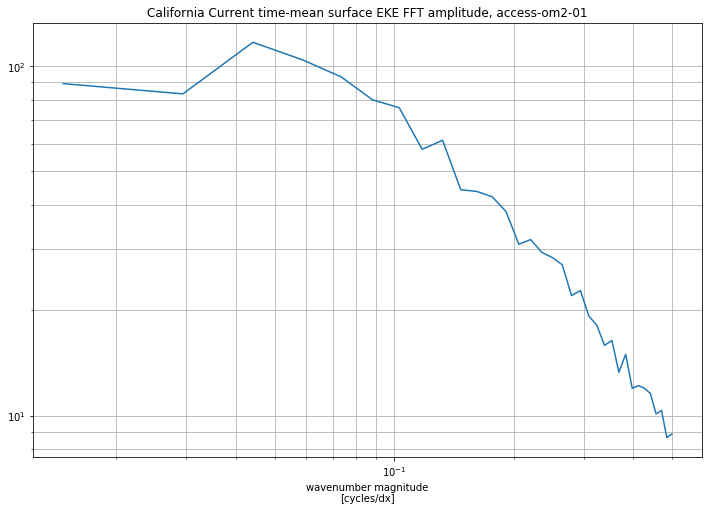

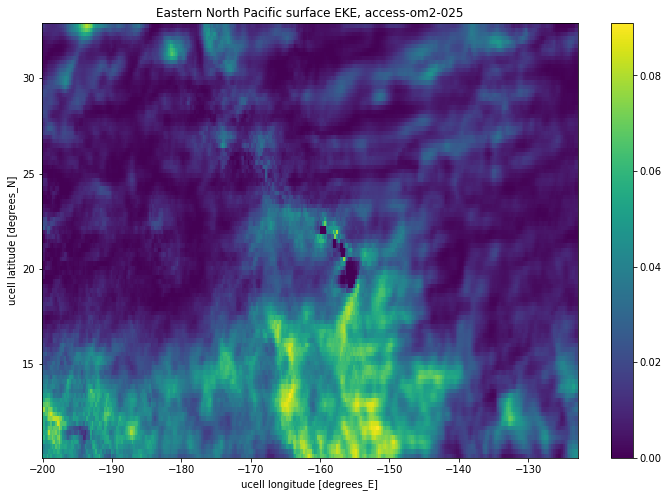

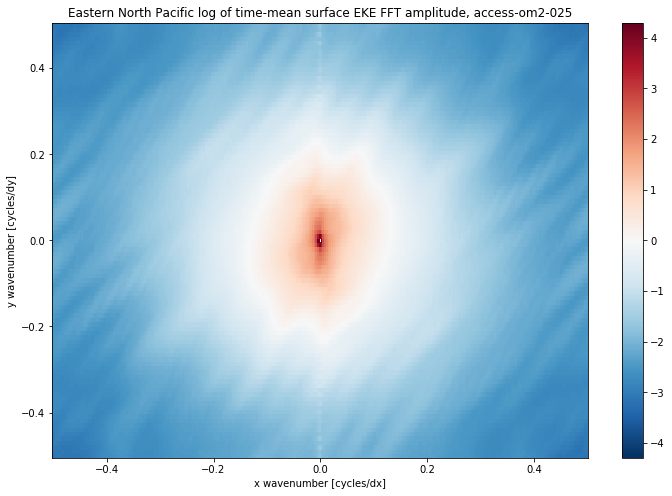

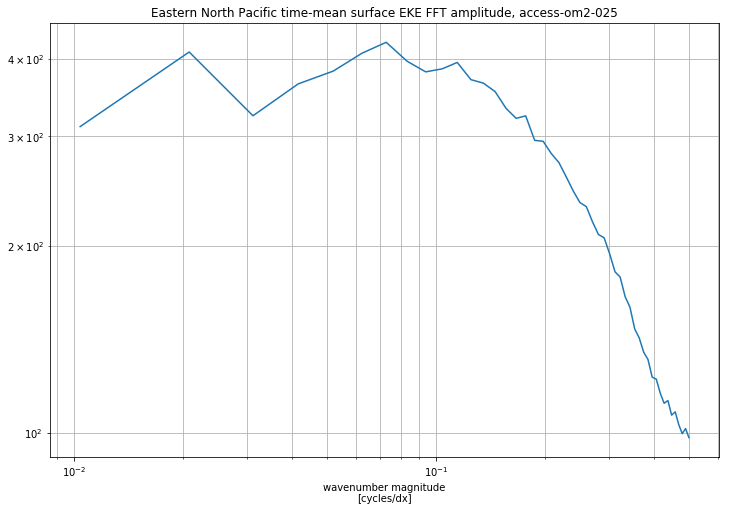

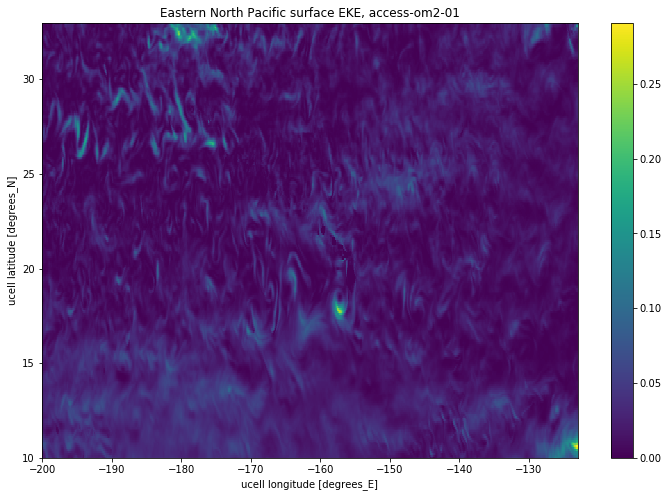

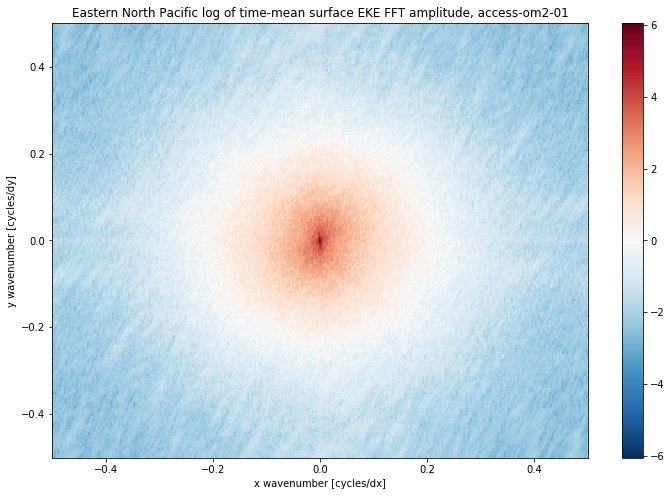

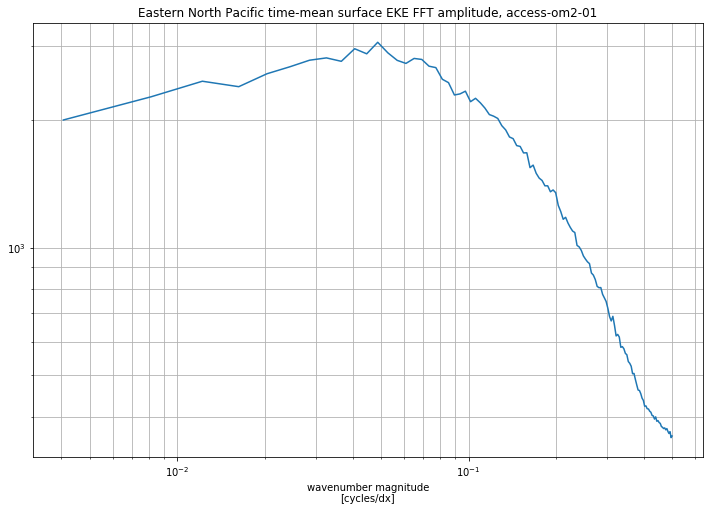

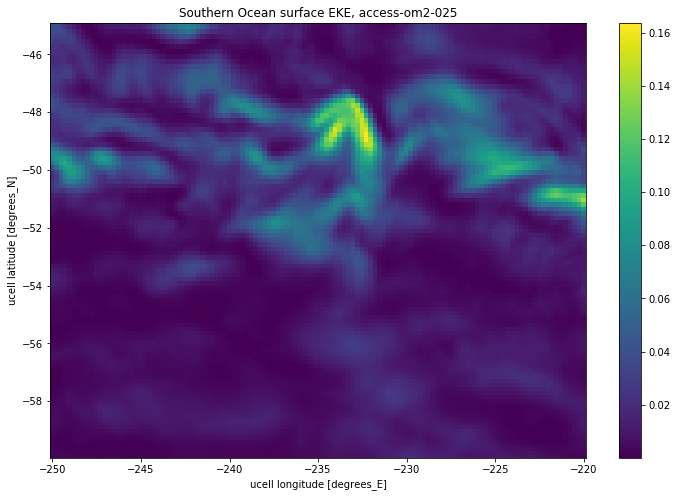

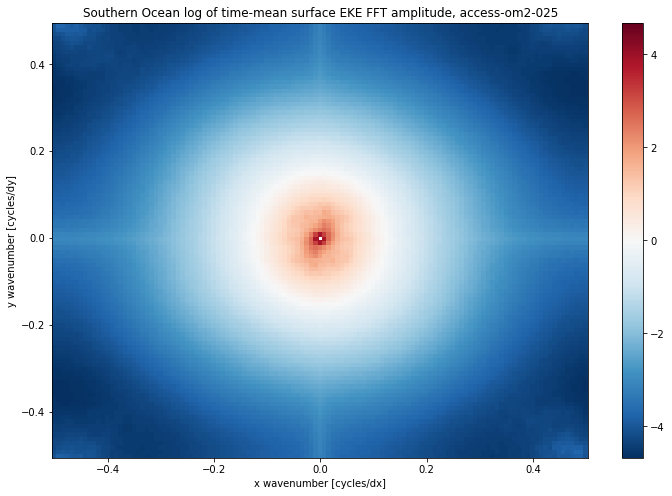

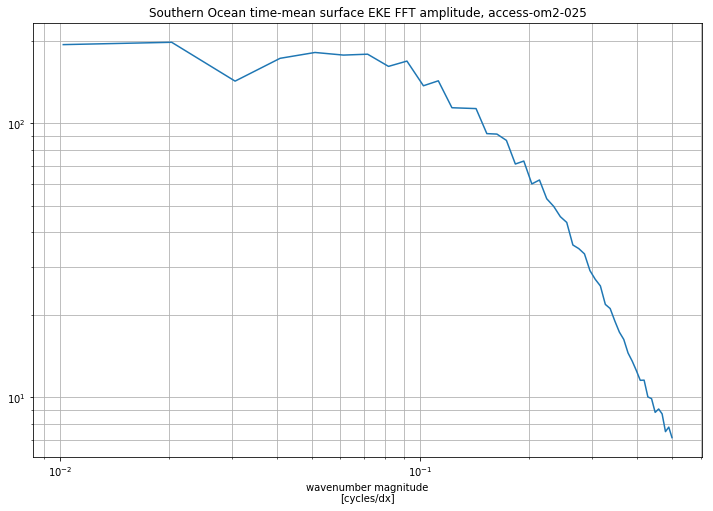

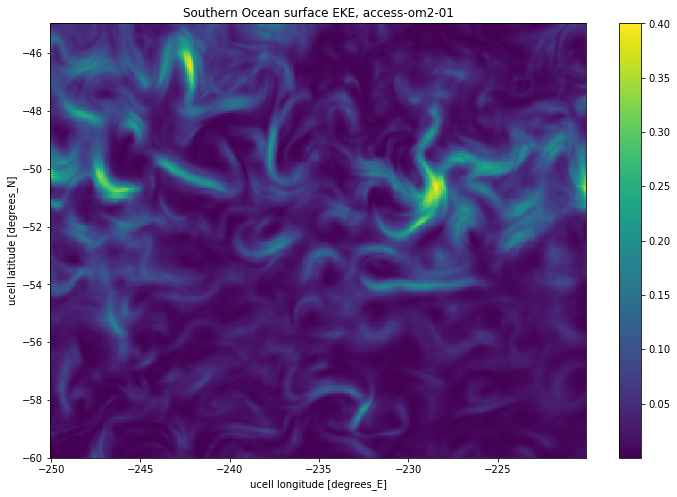

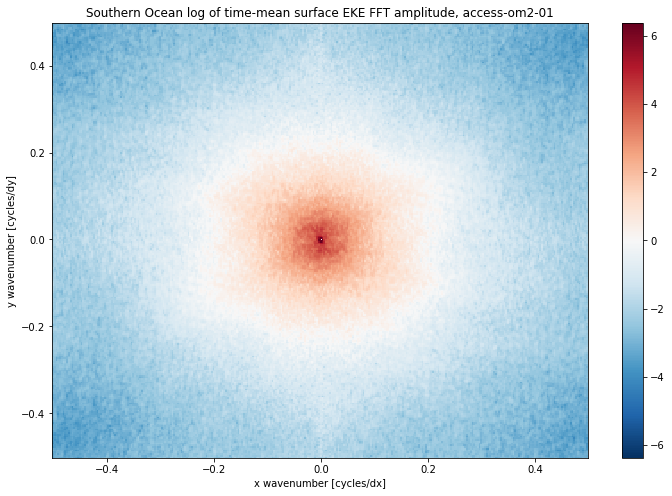

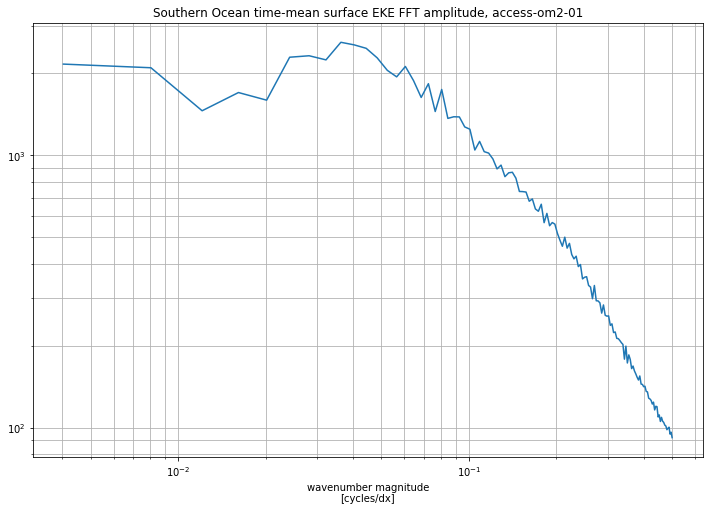

In [14]:
for locname,loc in locations.items():
    for ekey in ekes.keys():
        ke = ekes[ekey]['eke'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))

        fig = plt.figure(figsize=(12,8))
        ke.isel(time=0).plot()
        plt.title(locname+' surface EKE, '+ekes[ekey]['model'])

        kefft = fftgrid(ke)

        fig2 = plt.figure(figsize=(12,8))
        np.log(kefft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
        plt.title(locname+' log of time-mean surface EKE FFT amplitude, '+ekes[ekey]['model'])

        kefftradial = azimuthal_sum(kefft)
        fig2 = plt.figure(figsize=(12,8))
        kefftradial.plot(xscale='log', yscale='log')
        plt.grid(which='both', axis='both')
        plt.title(locname+' time-mean surface EKE FFT amplitude, '+ekes[ekey]['model'])

## Surface enstrophy spectra

In [15]:
# load model surface vorticity snapshots
ekey = '01deg'
vort = cc.get_nc_variable('01deg_jra55v13_iaf', 'ocean_snapshot.nc', 'vorticity_z',use_cache=use_cache).isel(st_ocean=0)
vort = vort.fillna(0.0) # fill and with zeros

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_snapshot.nc_vorticity_z_None_days-since-1900-01-01_None_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


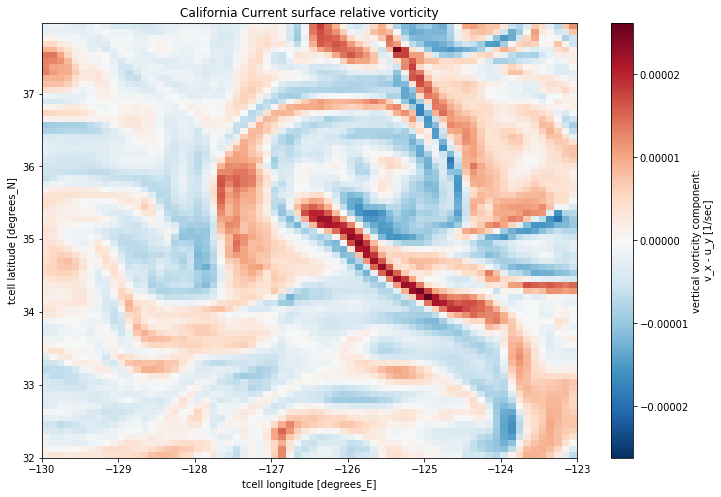

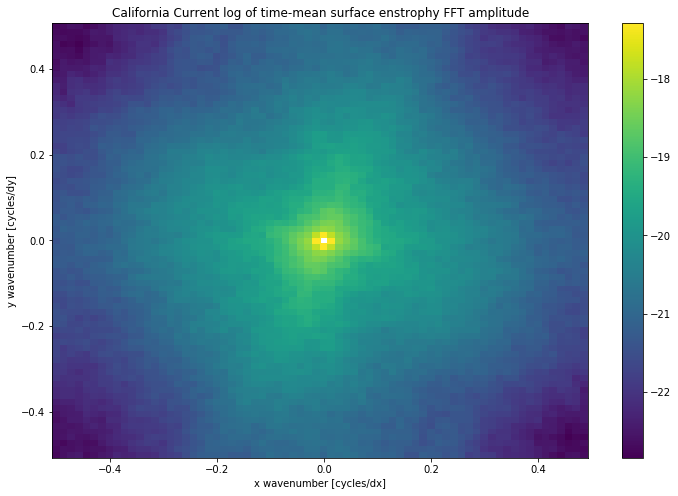

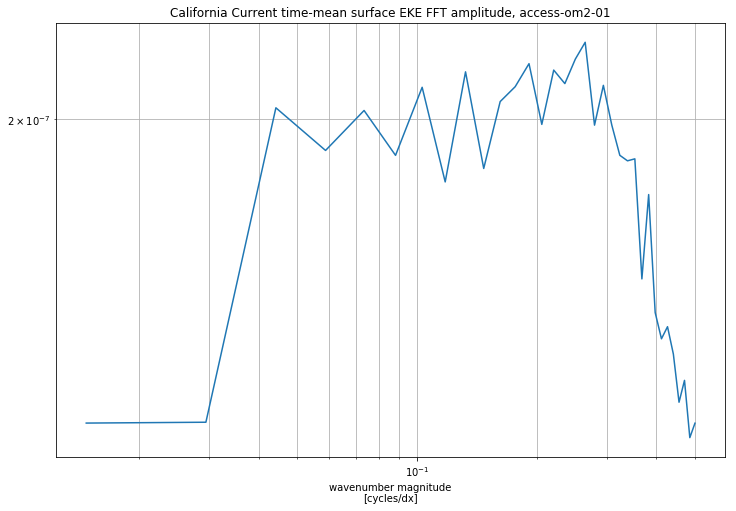

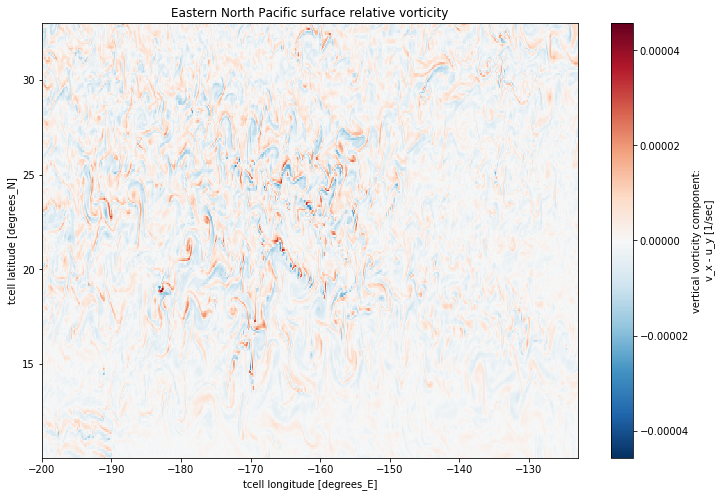

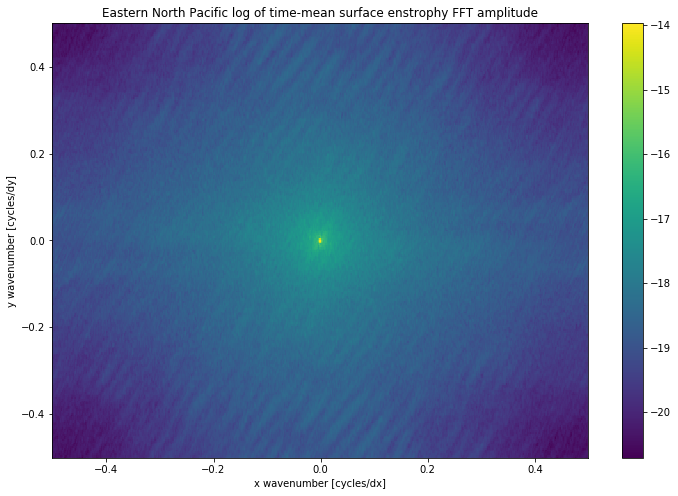

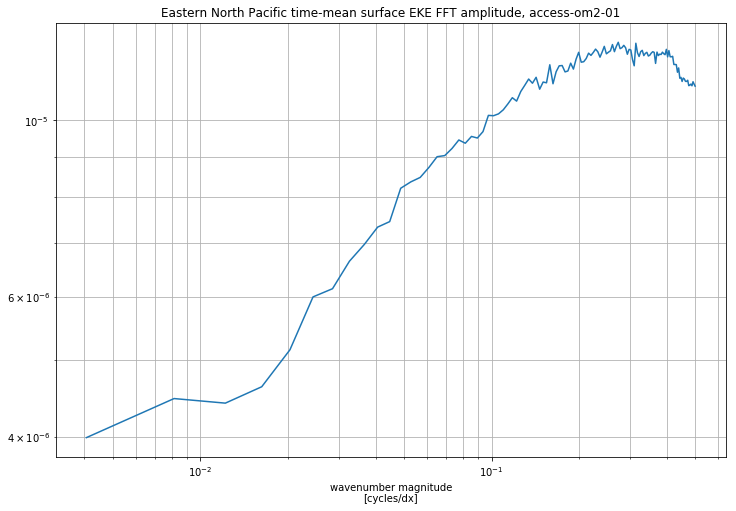

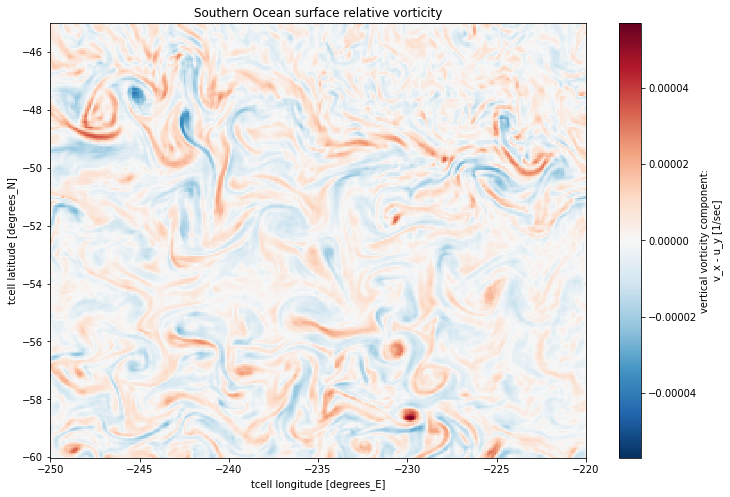

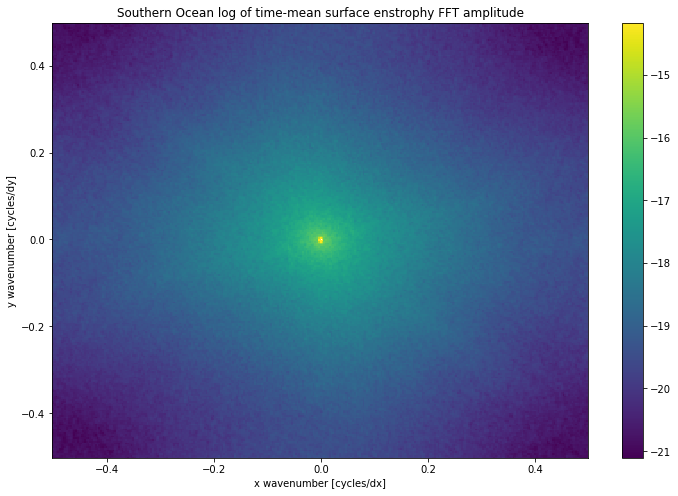

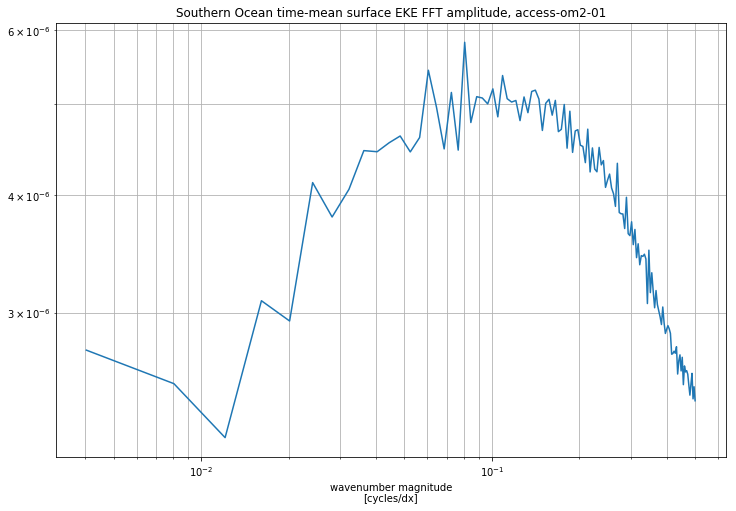

In [16]:
for locname,loc in locations.items():
    v = vort.sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
#     tdim, ydim, xdim = v.dims  # abstract out dimension names - NB: assumes this order of dimensions
#     nx = v[xdim].size
#     ny = v[ydim].size

    fig = plt.figure(figsize=(12,8))
    v.isel(time=0).plot()
    plt.title(locname+' surface relative vorticity')

    v2 = v**2
# #     fig = plt.figure(figsize=(12,8))
# #     v2.isel(time=0).plot()
# #     plt.title(locname+' surface enstrophy')

    v2dtfft = fftgrid(v2)

    fig2 = plt.figure(figsize=(12,8))
    np.log(v2dtfft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
    plt.title(locname+' log of time-mean surface enstrophy FFT amplitude')

    v2dtfftradial = azimuthal_sum(v2dtfft)
    fig2 = plt.figure(figsize=(12,8))
    v2dtfftradial.plot(xscale='log', yscale='log')
    plt.grid(which='both', axis='both')
    plt.title(locname+' time-mean surface EKE FFT amplitude, '+ekes[ekey]['model'])
#     break

# TODO
- first test with dummy data with known spectral content
- interpolate onto grid in units of metres (choose a power of 2)
- remove trends from interpolated data - see Errico1985a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
- remove mean (do this with interpolated data so it is area-weighted)
- 2d FFT
- calc squared magnitude
- convert to spectrum wrt |k| - see DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
